In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import json
import networkx as nx
import os

In [2]:
cvefixes = pd.read_csv("CVEfixes/CVEfixes_new.csv")
msr = pd.read_csv("Bigvul/MSR.csv")

# Load the JSON file representing the hierarchical structure
with open("preprocessed_datasets/debug_datasets/graph_all_paths.json", "r") as json_file:
    cwe_paths = json.load(json_file)

In [3]:
cwe_paths

{'0': ['10000-0'],
 '20': ['10000-1000-707-20'],
 '22': ['10000-1000-664-706-22'],
 '23': ['10000-1000-664-706-22-23'],
 '27': ['10000-1000-664-706-22-23-27'],
 '59': ['10000-1000-664-706-59'],
 '73': ['10000-1000-664-669-642-73', '10000-1000-664-610-73'],
 '74': ['10000-1000-707-74'],
 '77': ['10000-1000-707-74-77'],
 '78': ['10000-1000-707-74-77-78'],
 '79': ['10000-1000-707-74-79'],
 '80': ['10000-1000-707-74-79-80'],
 '88': ['10000-1000-707-74-77-88'],
 '89': ['10000-1000-707-74-943-89'],
 '90': ['10000-1000-707-74-943-90'],
 '91': ['10000-1000-707-74-91'],
 '93': ['10000-1000-707-74-93'],
 '94': ['10000-1000-707-74-94', '10000-1000-664-913-94'],
 '98': ['10000-1000-664-706-98', '10000-1000-664-669-829-98'],
 '113': ['10000-1000-707-74-93-113', '10000-1000-435-436-113'],
 '116': ['10000-1000-707-116'],
 '119': ['10000-1000-664-118-119'],
 '120': ['10000-1000-664-118-119-120'],
 '121': ['10000-1000-664-118-119-787-121', '10000-1000-664-118-119-788-121'],
 '122': ['10000-1000-664-118

In [4]:
filtered_df = cvefixes[cvefixes.isna().any(axis=1)]
print(filtered_df.shape)
filtered_df.isna().sum() # 20 nan in code, 20 nan in all other cols


(40, 4)


code      20
cwe_id    20
cve_id    20
vul       20
dtype: int64

In [5]:
cvefixes = cvefixes.dropna()
print(cvefixes.isna().sum())
cvefixes['cwe_id'] = cvefixes['cwe_id'].astype(int)
cvefixes['vul'] = cvefixes['vul'].astype(int)
cvefixes.head(5)

code      0
cwe_id    0
cve_id    0
vul       0
dtype: int64


,code,cwe_id,cve_id,vul
0,expand_dynamic_string_token (struct link_map *...,252,CVE-1999-0199,1
1,"_dl_dst_substitute (struct link_map *l, const ...",252,CVE-1999-0199,1
2,"_dl_dst_count (const char *name, int is_path)\...",252,CVE-1999-0199,1
3,"vsyslog(pri, fmt, ap)\n\tint pri;\n\tregister ...",252,CVE-1999-0199,1
4,init_syntax_once ()\n{\n register int c;\n ...,252,CVE-1999-0199,1


In [6]:
msr = msr.dropna()
msr.drop(columns=['Unnamed: 0'], inplace=True) 
msr.head(5)

,code,cwe_id,cve_id,vul
0,static PHP_FUNCTION(preg_match)\n{\n\tphp_do_p...,119,CVE-2015-8382,0
1,static PHP_FUNCTION(preg_match_all)\n{\n\tphp_...,119,CVE-2015-8382,0
2,static PHP_FUNCTION(preg_replace)\n{\n\tpreg_r...,119,CVE-2015-8382,0
3,static PHP_FUNCTION(preg_replace_callback)\n{\...,119,CVE-2015-8382,0
4,static PHP_FUNCTION(preg_filter)\n{\n\tpreg_re...,119,CVE-2015-8382,0


In [7]:
# Add hash column for code, to check for uniqueness
cvefixes['code.digest'] = cvefixes['code'].apply(lambda x: hashlib.sha1(x.encode()).hexdigest())
msr['code.digest'] = msr['code'].apply(lambda x: hashlib.sha1(x.encode()).hexdigest())

# # Remove code column
# cvefixes.drop(columns=['code'], inplace=True)
# msr.drop(columns=['code'], inplace=True)

# Combine datasets
alltbl = pd.concat([cvefixes, msr]).drop_duplicates()

alltbl['classpath'] = alltbl['cwe_id'].astype(str).map(cwe_paths)
alltbl['cwe_id'] = alltbl['cwe_id'].astype(int)
alltbl

,code,cwe_id,cve_id,vul,code.digest,classpath
0,expand_dynamic_string_token (struct link_map *...,252,CVE-1999-0199,1,5dfc31742fe5030464ddc789a8e939599bbab1a4,[10000-1000-703-754-252]
1,"_dl_dst_substitute (struct link_map *l, const ...",252,CVE-1999-0199,1,80ed4967cd5e6575ea7f9b0b471dc512be5cad41,[10000-1000-703-754-252]
2,"_dl_dst_count (const char *name, int is_path)\...",252,CVE-1999-0199,1,bdded5aedc003abdaca0471fb4a2dd9070f8a919,[10000-1000-703-754-252]
3,"vsyslog(pri, fmt, ap)\n\tint pri;\n\tregister ...",252,CVE-1999-0199,1,402d73979bf2a32ea656a71b93a912c7027a389c,[10000-1000-703-754-252]
4,init_syntax_once ()\n{\n register int c;\n ...,252,CVE-1999-0199,1,eb7ca045e999b9b6d086171176fa9b92d214bad8,[10000-1000-703-754-252]
...,...,...,...,...,...,...
145738,void impeg2d_dec_p_mb_params(dec_state_t *ps_d...,119,CVE-2016-0835,1,6b7fad7b957c6e130245163cbb07cc6df3863bdf,[10000-1000-664-118-119]
145739,void impeg2d_dec_pnb_mb_params(dec_state_t *ps...,119,CVE-2016-0835,1,fcdbb0685326dcd81cdb6f027cc61de89674b089,[10000-1000-664-118-119]
145740,int equalizer_get_parameter(effect_context_t *...,200,CVE-2017-0402,1,a792513015548d99e3d8b8d5600f843665711434,[10000-1000-664-668-200]
145741,"uint8_t rfc_parse_data(tRFC_MCB* p_mcb, MX_FRA...",125,CVE-2018-9503,1,4c73479fff542238b2861c96bac10887e973a4fa,[10000-1000-664-118-119-125]


In [8]:

# statistics about codes in the same cve_id that are vulnerable and have different cwe_ids assigned
grouped = alltbl[alltbl['cwe_id'] != 0].groupby(['cve_id', 'code.digest'])['cwe_id'].agg([('cwe_id_count', 'nunique'), ('cwe_ids', lambda x: sorted(list(x.unique())))])

filtered = grouped[grouped['cwe_id_count'] > 1].reset_index()

print(filtered['cwe_ids'].value_counts().to_string())

[125, 787]         314
[190, 787]          39
[362, 416]          25
[119, 787]          20
[378, 379]          16
[22, 78, 918]       15
[20, 918]           15
[285, 346]          12
[20, 346]           11
[470, 502]          11
[119, 805]          10
[119, 788]          10
[20, 476]            9
[79, 352]            7
[191, 787]           7
[193, 787]           6
[416, 476]           6
[59, 362]            5
[125, 776]           5
[119, 200]           5
[125, 416, 787]      5
[119, 825]           4
[362, 416, 476]      4
[682, 787]           4
[252, 401]           4
[119, 190]           4
[20, 94]             4
[287, 303]           4
[20, 617]            4
[120, 362]           3
[125, 476]           3
[459, 909]           3
[74, 277]            3
[200, 416]           3
[122, 787]           3
[754, 863, 908]      2
[125, 362]           2
[74, 79]             2
[20, 787]            2
[295, 297]           2
[190, 401]           2
[79, 434]            2
[601, 918]           2
[120, 122] 

In [9]:
# Create a DataFrame with counts for each cwe_id
cwecounts = alltbl.groupby('cwe_id').size().reset_index(name='count')
print(cwecounts.to_string())

     cwe_id  count
0         0  59109
1        20  23049
2        22   1440
3        23      2
4        27      1
5        59   1169
6        73     12
7        74    850
8        77    309
9        78    751
10       79   3977
11       80      1
12       88     78
13       89   7111
14       90     22
15       91     45
16       93   2349
17       94    640
18       98      1
19      113      1
20      116     23
21      119  27331
22      120    341
23      121      5
24      122     53
25      125   9351
26      126      5
27      129    293
28      131      8
29      134    675
30      172     28
31      178      6
32      184      1
33      185      2
34      190   4187
35      191    100
36      193     13
37      200   9134
38      203     29
39      208      1
40      209      4
41      212      5
42      241      7
43      252     24
44      269    995
45      273      3
46      276     40
47      277      3
48      281     57
49      284   2467
50      285    488
51      287 

In [10]:
def create_graph_from_json(paths_dict_data, max_depth=None):
    
    G = nx.DiGraph()

    def add_path_to_graph(path):
        nodes = list(map(int, path.split('-')))
        if max_depth:
            max_level = min(max_depth, len(nodes) - 1)
            for i in range(max_level):
                G.add_edge(nodes[i], nodes[i+1])
        else:
            for i in range(len(nodes) - 1):
                G.add_edge(nodes[i], nodes[i+1])

    # Add edges from the paths in the JSON data
    for key, paths_list in paths_dict_data.items():
        for path in paths_list:
            add_path_to_graph(path)
            
    return G

graph = create_graph_from_json(cwe_paths)
node_list = list(graph.nodes)

In [11]:
# for reassignment, we are going to use a tree.
# if a node has multiple predecessors, we choose the predecessor with more items in the dataset.

def choose_favorite_parent(node):
    parents = list(graph.predecessors(node))
    if len(parents) == 1:
        return parents[0]
    num_parent_samples = list()
    for p in parents:
        parent_family = nx.ancestors(graph, p) - set.union(*(nx.ancestors(graph, otherp) for otherp in parents if otherp != p))
        if parent_family:
            parent_descendants = set.union(*(nx.descendants(graph, x) for x in parent_family)).union(parent_family)
        else:
            parent_descendants = parent_family
        num_parent_samples.append(
            cwecounts[cwecounts['cwe_id'].isin(parent_descendants)]['count'].sum()
        )
    return(parents[num_parent_samples.index(max(num_parent_samples))])

graph_unique = nx.DiGraph()
for node in list(nx.topological_sort(graph))[1:]:
    graph_unique.add_edge(choose_favorite_parent(node), node)

In [12]:
def splitclass(df, split_class):
    df = df.copy()
    results = [df.loc[df['assignedclass'] != split_class]]  # items that are not touched
    split_into = set(graph_unique.neighbors(split_class))
    for cwe_id in df.loc[df['assignedclass'] == split_class]['cwe_id']:
        new_assignedclasses = split_into.intersection(
            nx.ancestors(graph_unique, cwe_id).union({cwe_id})
        )
        if not new_assignedclasses:
            # no children to split into -> don't split
            new_assignedclasses = {split_class}
        for ac in new_assignedclasses: # could be multiple
            newline = df.loc[(df['cwe_id'] == cwe_id) & (df['assignedclass'] == split_class)].copy()
            newline['assignedclass'] = ac
            results.append(newline)
    return pd.concat(results).drop_duplicates()

In [13]:
# cweiter = cwecounts.copy()
# cweiter['assignedclass'] = 10000
# cweiter = cweiter[:7]


In [14]:
# print(cweiter)

In [15]:
# cweiter = splitclass(cweiter, 706)
# print(cweiter)

In [16]:
# cutoff = 1000
# get_worth_splitting(cweiter,cutoff)

In [17]:
def check_worth_splitting(df, split_class, cutoff):
    num_above_cutoff = sum(df.loc[df['assignedclass'] == split_class]['count'] >= cutoff)
    return num_above_cutoff > 1

In [18]:
def get_worth_splitting(df, cutoff):
    return [x for x in set(df['assignedclass']) if check_worth_splitting(df, x, cutoff)]

In [19]:
cutoff = 1000 #################################################

In [20]:
cweiter = cwecounts.copy()
cweiter['assignedclass'] = 10000
while True:
    splitting = get_worth_splitting(cweiter, cutoff)
    if not splitting:
        break
    cweiter = splitclass(cweiter, splitting[0])

manual_classes = [284]
for manual_cwe in manual_classes:
    cweiter = splitclass(cweiter, manual_cwe)

In [21]:
cweiter

,cwe_id,count,assignedclass
0,0,59109,0
28,131,8,682
32,184,1,697
33,185,2,697
34,190,4187,682
...,...,...,...
90,425,1,285
104,521,25,287
116,640,39,287
154,862,187,285


In [22]:
len(cweiter['cwe_id'].unique())

171

In [23]:
len(cweiter)

171

In [24]:
check = cweiter.copy()
check = check[check['assignedclass']==284]

In [25]:
print(splitclass(check, 284).to_string())

    cwe_id  count  assignedclass
49     284   2467            284


In [26]:
check2 = cweiter.copy()
check2 = check2[check2['assignedclass']==404]
print(splitclass(check2, 404).to_string())

     cwe_id  count  assignedclass
86      401     85            772
87      404    926            404
98      459      3            459
137     763     49            763
139     772   1257            772


In [27]:
cweiter.sort_values('assignedclass')

,cwe_id,count,assignedclass
0,0,59109,0
27,129,293,20
1,20,23049,20
3,23,2,22
4,27,1,22
...,...,...,...
162,922,1,922
13,89,7111,943
14,90,22,943
164,943,1,943


In [28]:
print(cweiter.sort_values('assignedclass').to_string())
# 284, 404

     cwe_id  count  assignedclass
0         0  59109              0
27      129    293             20
1        20  23049             20
3        23      2             22
4        27      1             22
2        22   1440             22
5        59   1169             59
115     639    433             66
7        74    850             74
12       88     78             77
9        78    751             77
8        77    309             77
11       80      1             79
10       79   3977             79
15       91     45             91
16       93   2349             93
19      113      1             93
20      116     23            116
117     644      2            116
21      119  27331            119
22      120    341            120
25      125   9351            125
26      126      5            125
29      134    675            134
30      172     28            172
31      178      6            178
39      208      1            200
40      209      4            200
37      200   

In [29]:
print(cweiter.groupby('assignedclass')['count'].sum().sort_values(ascending = False).reset_index().to_string())

    assignedclass  count
0               0  59109
1             119  27331
2              20  23342
3             825  10127
4             125   9356
5             200   9278
6             943   7134
7             362   6322
8             703   5505
9             682   5172
10            787   3990
11             79   3978
12            284   2467
13             93   2350
14            404   2320
15            400   2236
16            610   1706
17            732   1647
18            693   1470
19             22   1443
20            834   1396
21            666   1365
22            287   1266
23            913   1212
24             59   1169
25             77   1138
26            670   1133
27            269    998
28            704    959
29            285    924
30             74    850
31            134    675
32             66    433
33            120    341
34            435    248
35            669    208
36            665    144
37            710     92
38            668     76


In [30]:
cweiter_stat = cweiter.groupby('assignedclass')['count'].sum().sort_values(ascending = False).reset_index()
cweiter_stat

,assignedclass,count
0,0,59109
1,119,27331
2,20,23342
3,825,10127
4,125,9356
...,...,...
56,823,3
57,552,3
58,428,2
59,786,1


In [31]:
cweiter_stat['count'].sum()

201265

In [32]:
cweiter_stat[cweiter_stat['count']>=cutoff]['count'].sum() / cweiter_stat['count'].sum()

0.9686830795220231

In [33]:
cweiter_1000 = cweiter[cweiter['count']>=cutoff]
cweiter_1000.to_csv('preprocessed_datasets/assigined_cwe_cutoff1000.csv')

cweiter_1000

In [42]:
# Merge or join the DataFrames based on cwe_id
def merge_assignclass_and_drop_by_cutoff(df,cweiter,cutoff,output_dir):
    df_reassign = df.merge(cweiter, on='cwe_id', how='left')
    df_reassign = df_reassign.drop('code.digest', axis=1)
    
    df_reassign = df_reassign[df_reassign['count'] >= cutoff]
    
    df_reassign.to_csv(output_dir)
    return df_reassign
    

In [43]:
CVEfixes_reassign = merge_assignclass_and_drop_by_cutoff(cvefixes,cweiter,cutoff,output_dir='CVEfixes/CVEfixes_reassign.csv')
CVEfixes_reassign

,code,cwe_id,cve_id,vul,count,assignedclass
6,"process_chpw_request(krb5_context context, voi...",20,CVE-2002-2443,1,23049,20
7,"init_ctx_reselect(OM_uint32 *minor_status, spn...",415,CVE-2014-4343,1,1111,666
8,"acc_ctx_cont(OM_uint32 *minstat,\n\t gss_b...",476,CVE-2014-4344,1,4973,703
9,krb5_ldap_get_password_policy_from_dn(krb5_con...,476,CVE-2014-5353,1,4973,703
10,check_rpcsec_auth(struct svc_req *rqstp)\n{\n ...,284,CVE-2014-9422,1,2467,284
...,...,...,...,...,...,...
69164,const delimiter = `ghadelimiter_${uuidv4()...,0,CVE-2022-35954,0,59109,0
69165,private boolean isFileWithinDirectory(\n ...,0,CVE-2022-36007,0,59109,0
69166,func TestNegativePowerLevels(t *testing.T) {\n...,0,CVE-2022-36009,0,59109,0
69167,func NewPowerLevelContentFromEvent(event *Even...,0,CVE-2022-36009,0,59109,0


In [44]:
MSR_reassign = merge_assignclass_and_drop_by_cutoff(msr,cweiter,cutoff,output_dir='Bigvul/MSR_reassign.csv')
MSR_reassign

,code,cwe_id,cve_id,vul,count,assignedclass
0,static PHP_FUNCTION(preg_match)\n{\n\tphp_do_p...,119,CVE-2015-8382,0,27331,119
1,static PHP_FUNCTION(preg_match_all)\n{\n\tphp_...,119,CVE-2015-8382,0,27331,119
2,static PHP_FUNCTION(preg_replace)\n{\n\tpreg_r...,119,CVE-2015-8382,0,27331,119
3,static PHP_FUNCTION(preg_replace_callback)\n{\...,119,CVE-2015-8382,0,27331,119
4,static PHP_FUNCTION(preg_filter)\n{\n\tpreg_re...,119,CVE-2015-8382,0,27331,119
...,...,...,...,...,...,...
133100,void impeg2d_dec_p_mb_params(dec_state_t *ps_d...,119,CVE-2016-0835,1,27331,119
133101,void impeg2d_dec_pnb_mb_params(dec_state_t *ps...,119,CVE-2016-0835,1,27331,119
133102,int equalizer_get_parameter(effect_context_t *...,200,CVE-2017-0402,1,9134,200
133103,"uint8_t rfc_parse_data(tRFC_MCB* p_mcb, MX_FRA...",125,CVE-2018-9503,1,9351,125


In [45]:
# Combine two DataFrames and drop duplicates
combined_df = pd.concat([CVEfixes_reassign, MSR_reassign])
print(combined_df.shape)
combined_df = combined_df.drop_duplicates()
print(combined_df.shape)
# Display rows with NaN values
nan_rows = combined_df[combined_df.isna().any(axis=1)]
print(nan_rows)
combined_df = combined_df.dropna()
print(combined_df.shape)
combined_df

(184122, 6)
(183113, 6)
Empty DataFrame
Columns: [code, cwe_id, cve_id, vul, count, assignedclass]
Index: []
(183113, 6)


,code,cwe_id,cve_id,vul,count,assignedclass
6,"process_chpw_request(krb5_context context, voi...",20,CVE-2002-2443,1,23049,20
7,"init_ctx_reselect(OM_uint32 *minor_status, spn...",415,CVE-2014-4343,1,1111,666
8,"acc_ctx_cont(OM_uint32 *minstat,\n\t gss_b...",476,CVE-2014-4344,1,4973,703
9,krb5_ldap_get_password_policy_from_dn(krb5_con...,476,CVE-2014-5353,1,4973,703
10,check_rpcsec_auth(struct svc_req *rqstp)\n{\n ...,284,CVE-2014-9422,1,2467,284
...,...,...,...,...,...,...
133100,void impeg2d_dec_p_mb_params(dec_state_t *ps_d...,119,CVE-2016-0835,1,27331,119
133101,void impeg2d_dec_pnb_mb_params(dec_state_t *ps...,119,CVE-2016-0835,1,27331,119
133102,int equalizer_get_parameter(effect_context_t *...,200,CVE-2017-0402,1,9134,200
133103,"uint8_t rfc_parse_data(tRFC_MCB* p_mcb, MX_FRA...",125,CVE-2018-9503,1,9351,125


In [47]:
data_path = '../datasets_'
combined_df.to_csv(f"{data_path}/combined_dataset.csv")

In [48]:
unique_values = combined_df.nunique()
unique_values

code             169010
cwe_id               21
cve_id             6631
vul                   2
count                21
assignedclass        21
dtype: int64

In [50]:
combined_df[combined_df['cwe_id']!=combined_df['assignedclass']]

,code,cwe_id,cve_id,vul,count,assignedclass
7,"init_ctx_reselect(OM_uint32 *minor_status, spn...",415,CVE-2014-4343,1,1111,666
8,"acc_ctx_cont(OM_uint32 *minstat,\n\t gss_b...",476,CVE-2014-4344,1,4973,703
9,krb5_ldap_get_password_policy_from_dn(krb5_con...,476,CVE-2014-5353,1,4973,703
45,"set_string_2_svc(sstring_arg *arg, struct svc_...",772,CVE-2015-8631,1,1257,404
46,"setv4key_principal_2_svc(setv4key_arg *arg, st...",772,CVE-2015-8631,1,1257,404
...,...,...,...,...,...,...
132581,status_t BnSoundTriggerHwService::onTransact(\...,190,CVE-2015-1529,1,4187,682
132602,AMediaCodecCryptoInfo *AMediaCodecCryptoInfo_n...,190,CVE-2018-9491,1,4187,682
132609,"void btif_av_event_deep_copy(uint16_t event, c...",416,CVE-2018-9476,1,10115,825
132610,static void btif_av_event_free_data(btif_sm_ev...,416,CVE-2018-9476,1,10115,825


In [51]:
unique_cwe_ids = combined_df['assignedclass'].unique().tolist()
unique_cwe_ids = sorted(unique_cwe_ids)
print(len(unique_cwe_ids),unique_cwe_ids)

21 [0, 20, 22, 59, 79, 93, 119, 125, 200, 284, 362, 400, 404, 666, 670, 682, 703, 732, 787, 825, 943]


(201265, 5)


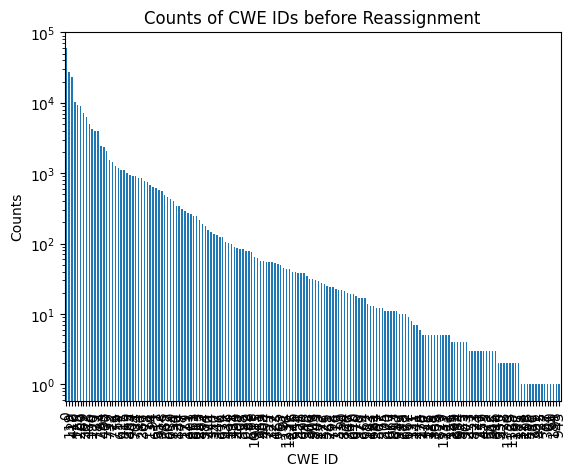

In [55]:
# Count unique values in 'cwe_id' column
combined_before_reassign_df = pd.concat([cvefixes, msr])
combined_before_reassign_df = combined_before_reassign_df.drop_duplicates()
nan_rows = combined_before_reassign_df[combined_before_reassign_df.isna().any(axis=1)]
combined_before_reassign_df = combined_before_reassign_df.dropna()
print(combined_before_reassign_df.shape)

cwe_counts = combined_before_reassign_df['cwe_id'].value_counts()
# Plotting
cwe_counts.plot(kind='bar', logy=True)
plt.xlabel('CWE ID')
plt.ylabel('Counts')
plt.title('Counts of CWE IDs before Reassignment')
plt.show()

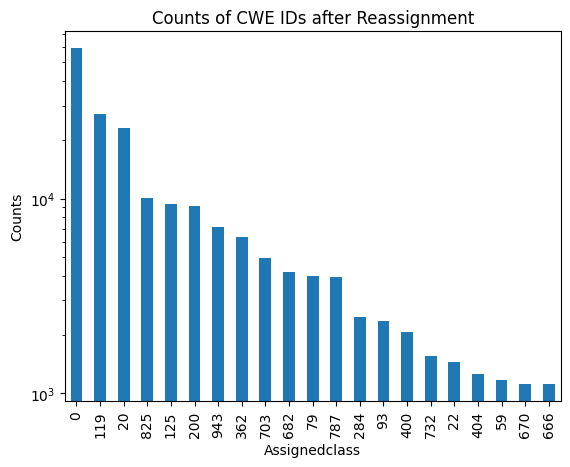

In [56]:
# Count unique values in 'assignedclass' column
cwe_counts = combined_df['assignedclass'].value_counts()
# Plotting
cwe_counts.plot(kind='bar', logy=True)
plt.xlabel('Assignedclass')
plt.ylabel('Counts')
plt.title('Counts of CWE IDs after Reassignment')
plt.show()

## Stratified split dataset to train/val/test set by CVE id group

In [61]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the distribution
def plot_distribution(dataset, title, col_name='assignedclass'):
    plt.figure(figsize=(12, 6))
    col_counts = dataset[col_name].value_counts()
    sns.barplot(x=col_counts.index, y=col_counts.values)
    plt.title(title)
    plt.ylabel('Number of Occurrences')
    plt.xlabel(col_name)
    plt.xticks(rotation=90)  # Rotates the x-axis labels to be more readable
    plt.show()

def stratify_dataset(df, col_name='assignedclass'):
    initial_allocation = defaultdict(lambda: {"train": 0, "validation": 0, "test": 0})

    # Initialize datasets
    train, validation, test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    random_state = 42


    for cwe_id, group in df.groupby(col_name):
    #     print("cwe_id, group",cwe_id, group)
        # For each cwe_id, allocate the first few cve_id groups to different datasets
        for i, (cve_id, cve_group) in enumerate(group.groupby('cve_id')):
            if i % 10 > 1:
                train = pd.concat([train, cve_group])
                initial_allocation[cwe_id]["train"] += len(cve_group)
            elif i % 10 == 1:
                validation = pd.concat([validation, cve_group])
                initial_allocation[cwe_id]["validation"] += len(cve_group)
            else:
                test = pd.concat([test, cve_group])
                initial_allocation[cwe_id]["test"] += len(cve_group)
    remaining_df = df[~df['cve_id'].isin(pd.concat([train, validation, test])['cve_id'])]
    print(remaining_df.shape)
    # if not remaining_df.empty:
    #     remaining_train, remaining_validation, remaining_test = split_group(remaining_df, len(remaining_df))
    #     train = pd.concat([train, remaining_train])
    #     validation = pd.concat([validation, remaining_validation])
    #     test = pd.concat([test, remaining_test])

    
    train = train.sample(frac=1, random_state=random_state).reset_index(drop=True)
    validation = validation.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test = test.sample(frac=1, random_state=random_state).reset_index(drop=True)
    print(train.shape[0], validation.shape[0], test.shape[0])
    return train, validation, test


(0, 6)
142517 20842 19754


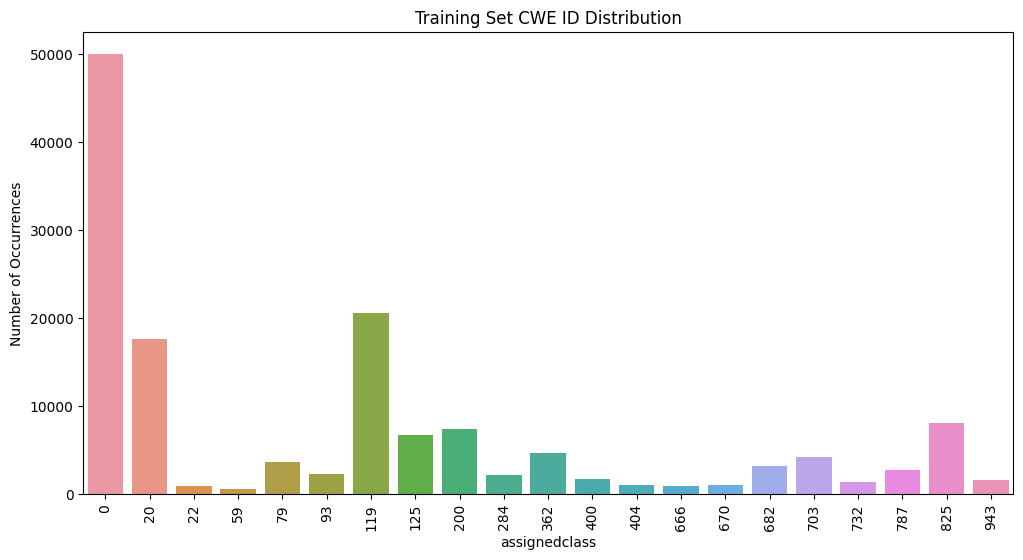

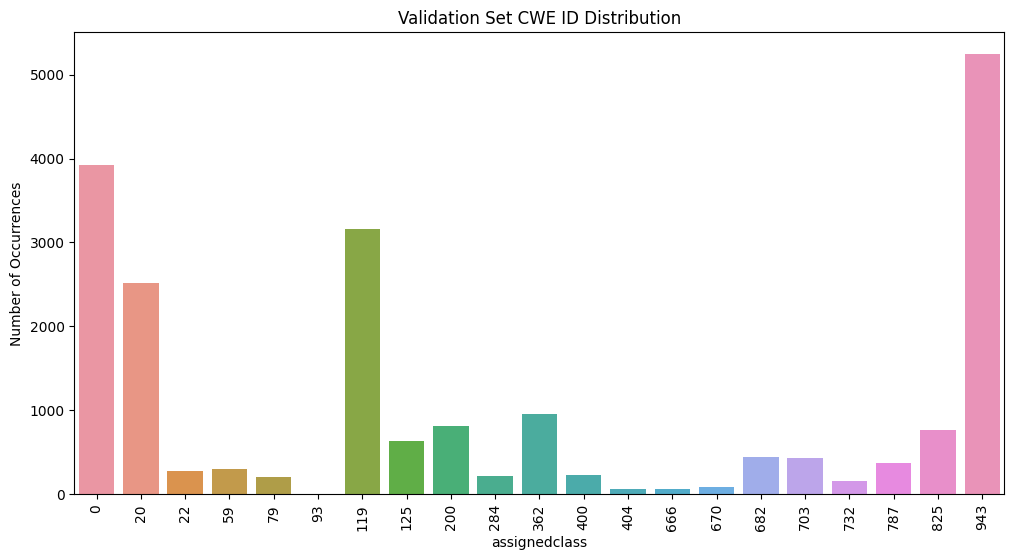

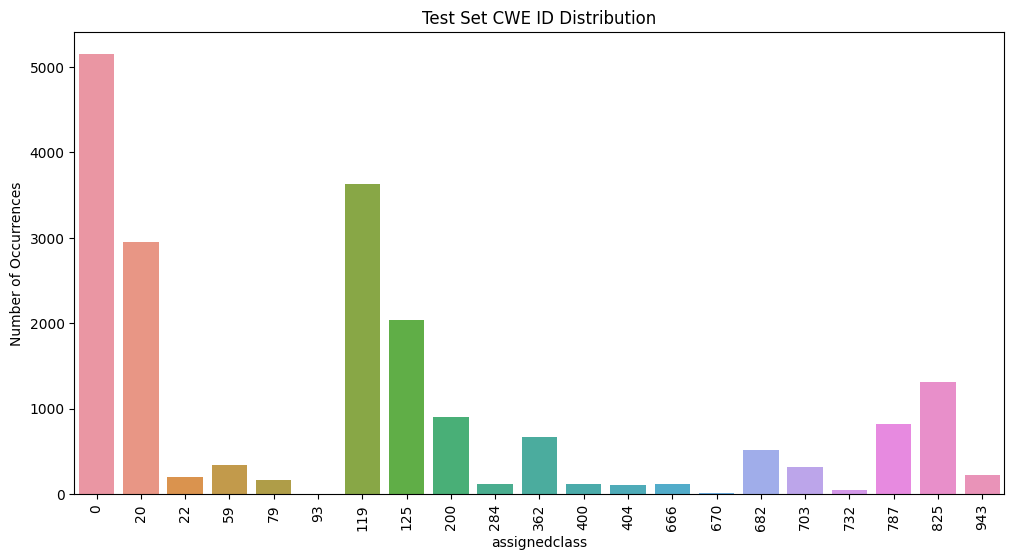

In [62]:
# Split Reassigned Dataset
train, validation, test = stratify_dataset(combined_df, col_name='assignedclass')

train.to_csv(f'{data_path}/train_dataset.csv', index=False)
validation.to_csv(f'{data_path}/validation_dataset.csv', index=False)
test.to_csv(f'{data_path}/test_dataset.csv', index=False)

# Plotting for each dataset
plot_distribution(train, 'Training Set CWE ID Distribution', 'assignedclass')
plot_distribution(validation, 'Validation Set CWE ID Distribution','assignedclass')
plot_distribution(test, 'Test Set CWE ID Distribution','assignedclass')


# # Split Original Combined Dataset
# ori_train, ori_validation, ori_test = stratify_dataset(combined_df, col_name='assignedclass')

# ori_train.to_csv(f'{data_path}/ori_train_dataset.csv', index=False)
# ori_validation.to_csv(f'{data_path}/ori_validation_dataset.csv', index=False)
# ori_test.to_csv(f'{data_path}/ori_test_dataset.csv', index=False)

# # Plotting for each dataset
# plot_distribution(ori_train, 'Original Training Set CWE ID Distribution')
# plot_distribution(ori_validation, 'Original Validation Set CWE ID Distribution')
# plot_distribution(ori_test, 'Original Test Set CWE ID Distribution')


In [63]:
def guess_samples_per_cwe_id(validation, target_sample_size, col_name = 'assignedclass'):
    num_unique_cwe_ids = validation[col_name].nunique()

    samples_per_cwe_id = target_sample_size // num_unique_cwe_ids
    while samples_per_cwe_id < len(validation):
        total_samples = 0
        for cwe_id in validation[col_name].unique():
            samples_to_take = min(samples_per_cwe_id, len(validation[validation[col_name] == cwe_id]))
            total_samples += samples_to_take

        if total_samples >= target_sample_size:
            break
        samples_per_cwe_id += 1
    return samples_per_cwe_id

def create_balanced_validation_dataset(validation, target_sample_size, col_name='assignedclass',random_state=42):

    # Calculate how many samples to take per CWE ID
    samples_per_cwe_id = guess_samples_per_cwe_id(validation, target_sample_size, col_name = 'assignedclass')
    
    # Sample the rows
    balanced_validation = pd.DataFrame()

    for cwe_id in validation[col_name].unique():
        # If there are not enough samples for a particular cwe_id, take all available
        samples_to_take = min(samples_per_cwe_id, len(validation[validation[col_name] == cwe_id]))
        sampled_group = validation[validation[col_name] == cwe_id].sample(n=samples_to_take, random_state=random_state)
        balanced_validation = pd.concat([balanced_validation, sampled_group])

    # Check if we have reached the target sample size
    current_sample_size = len(balanced_validation)

    # If the current sample size is less than the target, fill in the remaining with random samples from the validation set
    # IF it happens it would be a problem.
    if current_sample_size < target_sample_size:
        additional_samples = validation.sample(n=target_sample_size - current_sample_size, random_state=random_state)
        balanced_validation = pd.concat([balanced_validation, additional_samples])

    # Shuffle the balanced validation set
    balanced_validation = balanced_validation.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Update the validation DataFrame
    validation = balanced_validation
    print(validation.shape)
    return validation

(5008, 6)


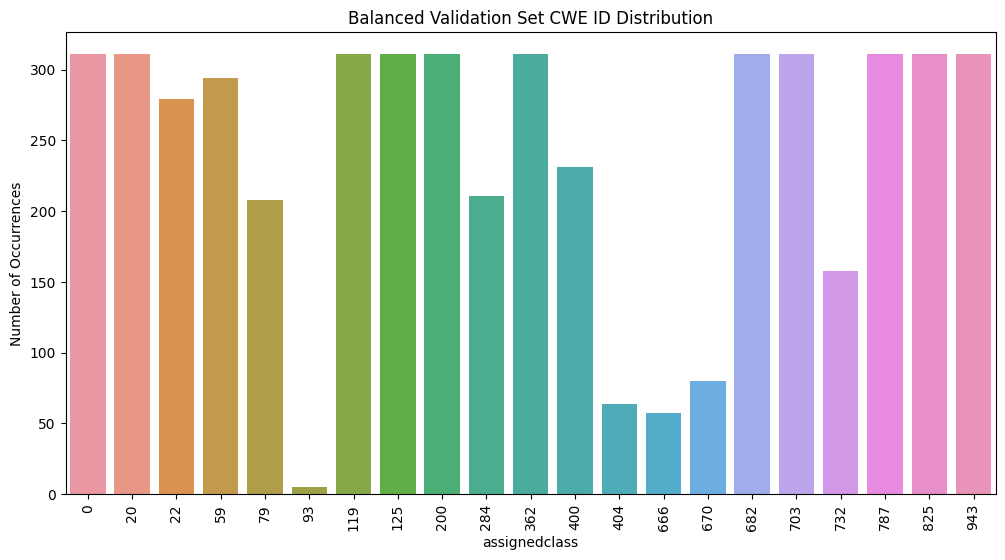

In [64]:
# Desired total sample size
target_sample_size = 5000
balanced_validation = create_balanced_validation_dataset(validation, target_sample_size, col_name='assignedclass')
# Output the sampled DataFrame
validation.to_csv(f'{data_path}/balanced_validation_dataset.csv', index=False)
plot_distribution(balanced_validation, 'Balanced Validation Set CWE ID Distribution')

# # Desired total sample size
# target_sample_size = 5000
# ori_balanced_validation = create_balanced_validation_dataset(ori_validation,target_sample_size, col_name='assignedclass')
# # Output the sampled DataFrame
# ori_balanced_validation.to_csv(f'{data_path}/ori_balanced_validation_dataset.csv', index=False)
# plot_distribution(ori_balanced_validation, 'Original Balanced Validation Set CWE ID Distribution')

# train.shape[0], validation.shape[0], test.shape[0]